In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

In [3]:
Train_path = "../datasets/Occupancy_detection/data_test.txt"
Test_path = "../datasets/Occupancy_detection/data_train.txt"

In [4]:
train_df = pd.read_csv(Train_path)
test_df = pd.read_csv(Test_path)
train_df = train_df.drop(['date'], axis=1)


In [5]:
test_df = test_df.drop(['date'], axis=1)

In [6]:
X_train, y_train = train_df.values[:, :-1], train_df.values[:, -1]
X_test, y_test = test_df.values[:, :-1], test_df.values[:, -1]

In [7]:
y_test

array([1., 1., 1., ..., 1., 1., 1.])

In [8]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/self.m_vertices)
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [9]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1

    Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
   
        

In [10]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.960213
Error Rate: 0.03978671041837567
Mean Recall: 0.9612025180557834
Balanced Accuracy Score: 0.9612025180557834
Precision: 0.9266396066837044
F-Score: 0.9424492575910182
Selectivity: 0.9594963001428015
G_mean: 0.9603490301772937


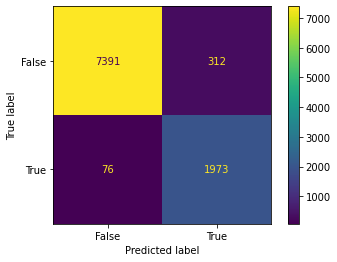

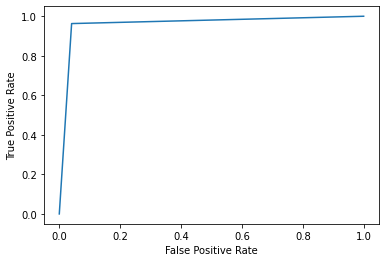

In [11]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.959085
Error Rate: 0.040914684167350335
Mean Recall: 0.9619214041140696
Balanced Accuracy Score: 0.9619214041140696
Precision: 0.9238470625441828
F-Score: 0.9410792075419259
Selectivity: 0.9570297286771388
G_mean: 0.9594724489989384


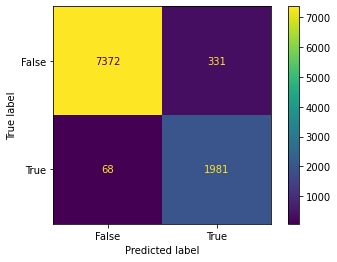

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.956214
Error Rate: 0.043785890073831046
Mean Recall: 0.9574172549253658
Balanced Accuracy Score: 0.9574172549253658
Precision: 0.919964667599712
F-Score: 0.9369238146112395
Selectivity: 0.9553420745164222
G_mean: 0.9563791018723784


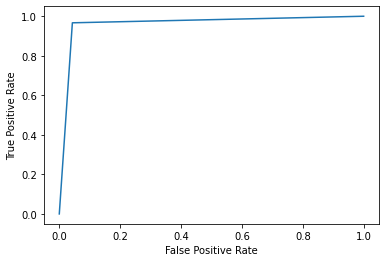

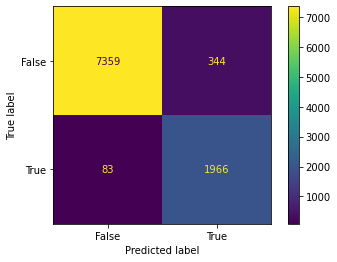

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.958983
Error Rate: 0.04101722723543888
Mean Recall: 0.9597071539569271
Balanced Accuracy Score: 0.9597071539569271
Precision: 0.9247407056697414
F-Score: 0.940708411665778
Selectivity: 0.9584577437362066
G_mean: 0.9590822453935077


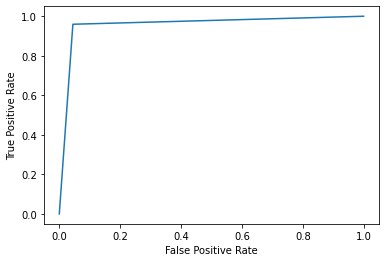

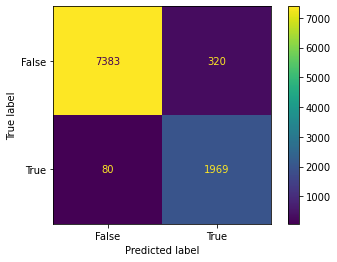

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.959906
Error Rate: 0.04009433962264153
Mean Recall: 0.962440682317367
Balanced Accuracy Score: 0.962440682317367
Precision: 0.9253395300005967
F-Score: 0.9421850060338303
Selectivity: 0.9580682850837337
G_mean: 0.9602519950526623


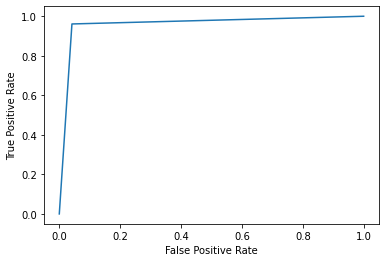

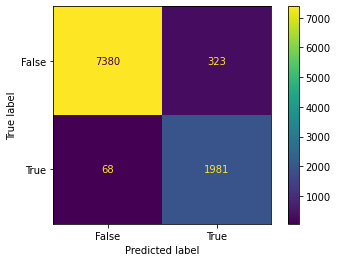

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.959085
Error Rate: 0.040914684167350335
Mean Recall: 0.961384069018637
Balanced Accuracy Score: 0.961384069018637
Precision: 0.9241135190428035
F-Score: 0.941021399448979
Selectivity: 0.9574191873296118
G_mean: 0.959399579982949


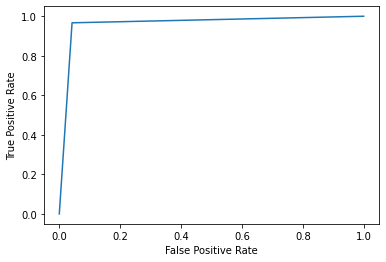

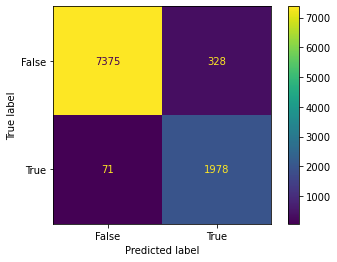

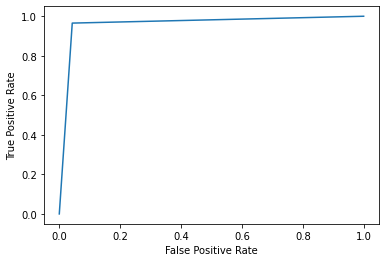

In [12]:
sm_list = []
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.950984
Error Rate: 0.04901558654634952
Mean Recall: 0.951778404299137
Balanced Accuracy Score: 0.951778404299137
Precision: 0.9117296655435065
F-Score: 0.9296766983354574
Selectivity: 0.9504089315850968
G_mean: 0.9510934214553852


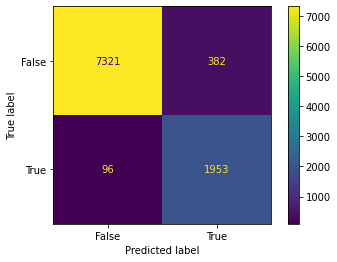

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.958060
Error Rate: 0.04194011484823623
Mean Recall: 0.9560780671040996
Balanced Accuracy Score: 0.9560780671040996
Precision: 0.9246183764458942
F-Score: 0.9391232892711088
Selectivity: 0.9594963001428015
G_mean: 0.9577856587118355


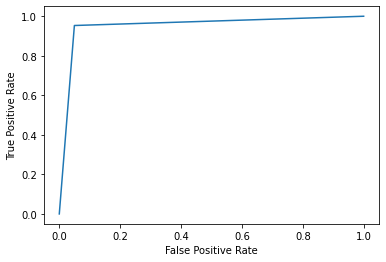

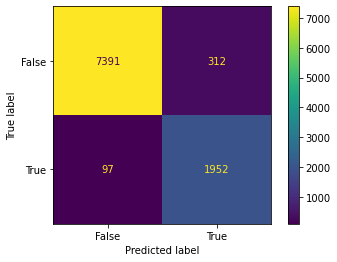

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.951292
Error Rate: 0.04870795734208366
Mean Recall: 0.9521522453238509
Balanced Accuracy Score: 0.9521522453238509
Precision: 0.9121913440130228
F-Score: 0.9301067366788279
Selectivity: 0.9506685706867454
G_mean: 0.9514101187911556


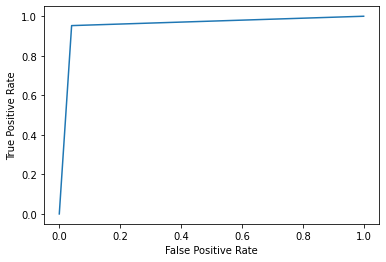

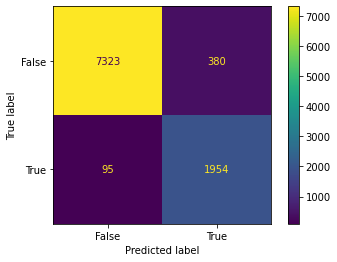

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.952933
Error Rate: 0.04706726825266616
Mean Recall: 0.9549819187152211
Balanced Accuracy Score: 0.9549819187152211
Precision: 0.9142847104742305
F-Score: 0.9325047623747896
Selectivity: 0.9514474879916915
G_mean: 0.9532130651848426


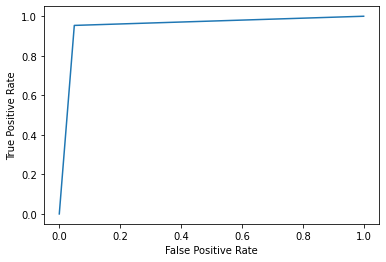

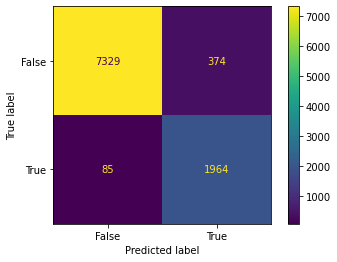

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.959085
Error Rate: 0.040914684167350335
Mean Recall: 0.9586973935414742
Balanced Accuracy Score: 0.9586973935414742
Precision: 0.9254872769194169
F-Score: 0.940729674059118
Selectivity: 0.9593664805919772
G_mean: 0.9590318787165449


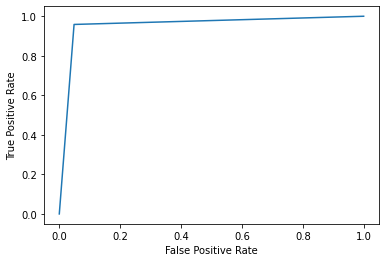

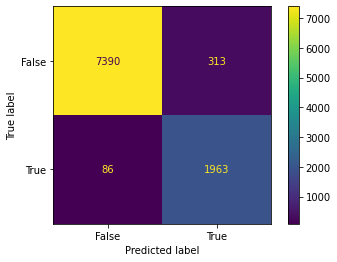

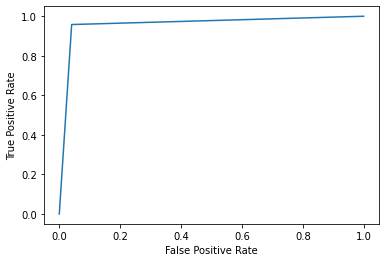

In [13]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))
for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)